In [4]:
import sys
import snap
import itertools
from IPython.display import Image, display


In [5]:
def get_nodes_and_edges(my_graph):
    n_nodes = my_graph.GetNodes()
    n_edges = my_graph.GetEdges()
    print(f"The graph has {n_nodes:,d} nodes, {n_edges:,d} edges.")

def show_g(graph, case_name, print_info=True):
    case_txt = case_name+".txt"
    case_png = case_name+".png"
    snap.DrawGViz(graph, snap.gvlDot, case_png, case_name)
    if print_info:
        get_nodes_and_edges(graph)
    return Image(case_png)

## Testing Zone

In [6]:
# create a directed random graph on X nodes and Y edges
g_er_random = snap.GenRndGnm(snap.PUNGraph, 5, 8)


In [7]:
# traverse the edges
for EI in g_er_random.Edges():
    print("edge (%d, %d)" % (EI.GetSrcNId(), EI.GetDstNId()))

snap.SaveEdgeList(g_er_random, "test_er_random.txt", "Save as tab-separated list of edges")

edge (0, 1)
edge (0, 2)
edge (0, 3)
edge (1, 2)
edge (1, 4)
edge (2, 3)
edge (2, 4)
edge (3, 4)


The graph has 5 nodes, 8 edges.


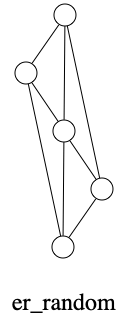

In [8]:
show_g(g_er_random, "er_random")

## Small World

In [9]:
## (Optional) Quick set-up of small world graph
## https://snap.stanford.edu/snappy/doc/reference/GenSmallWorld.html?highlight=smallworld#GenSmallWorld

# Rnd = snap.TRnd(1,0)
# g_sw_random = snap.GenSmallWorld(7, 1, 0, Rnd)
# show_g(g_sw_random, "sw_random")

In [56]:
import numpy as np

def generate_sw_graph(num_of_node, num_of_rand_edge_pair, show_info=False):
    the_graph = snap.TUNGraph.New()
    for i in range(num_of_node):
        the_graph.AddNode(i)
    for i in range(num_of_node):
        the_graph.AddEdge(int(i), int((i+1)%num_of_node))
        the_graph.AddEdge(int(i), int((i+2)%num_of_node))

    count = 0
    random_edge_set = set()
    while count < num_of_rand_edge_pair:
        rand_pair = np.random.choice(num_of_node, 2,replace=False) 
        node_id_a = int(rand_pair[0])
        node_id_b = int(rand_pair[1])
        if  (node_id_a < node_id_b) \
        and the_graph.AddEdge(node_id_a, node_id_b) == -1:
            the_graph.AddEdge(node_id_a, node_id_b) 
            random_edge_set.add((node_id_a, node_id_b))
            count+=1  

    if show_info: 
        get_nodes_and_edges(the_graph)
        print(random_edge_set)
    return the_graph
    


The graph has 6 nodes, 15 edges.
{(0, 3), (2, 5), (1, 4)}
The graph has 6 nodes, 15 edges.


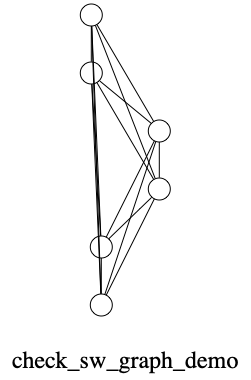

In [57]:
sw_graph_demo = generate_sw_graph(6, 3, show_info=True)
show_g(sw_graph_demo, "check_sw_graph_demo")

## Real World Data

In [23]:
case_name = "ca-GrQc"
case_txt = case_name+".txt"
g_real_world = snap.LoadEdgeList(snap.PNGraph, case_txt, 0, 1)

In [24]:
print("Original graph profile")
get_nodes_and_edges(g_real_world)

## https://snap.stanford.edu/snappy/doc/reference/DelSelfEdges.html?highlight=self
snap.DelSelfEdges(g_real_world)

print("Remove self-edge")
get_nodes_and_edges(g_real_world)

## https://snap.stanford.edu/snappy/doc/reference/ConvertGraph.html?highlight=undirect

# convert directed graph to undirected
g_real_world_un = snap.ConvertGraph(snap.PUNGraph, g_real_world)

print("Convert directed to undirected")
get_nodes_and_edges(g_real_world_un)


Original graph profile
The graph has 5,242 nodes, 28,980 edges.
Remove self-edge
The graph has 5,242 nodes, 28,968 edges.
Convert directed to undirected
The graph has 5,242 nodes, 14,484 edges.


In [25]:
def get_xy(graph_in):
    # vector of pairs of integers (size, count)
    CntV = snap.TIntPrV()
    # get degree distribution pairs (degree, count)
    snap.GetDegCnt(graph_in, CntV)

    ## Note:
    ## pair (x, y):  
    ## y is the number of nodes in the network 
    ## with degree equal to x.

    pair_list = []
    for item in CntV:
        if item.GetVal1() > 0:
            pair_list.append((item.GetVal1(), item.GetVal2()))
    
    x_data = [i[0] for i in pair_list]

    summation = sum(n for _, n in pair_list)
    y_data = [i[1]/summation for i in pair_list]
    return x_data, y_data

In [58]:
# n = 5, e = 8
n=5242
e=14484
g_er_random = snap.GenRndGnm(snap.PUNGraph, n, e)

num_of_node = n
num_of_rand_edge_pair = 4000
g_sw_random = generate_sw_graph(num_of_node, num_of_rand_edge_pair, show_info=False)

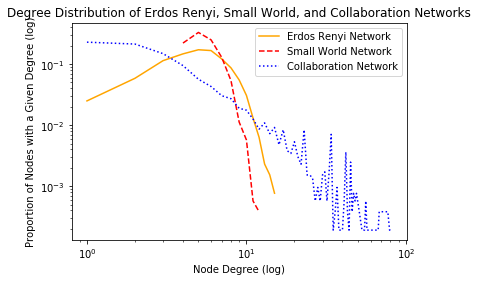

In [59]:
import matplotlib.pyplot as plt

x_erdosRenyi, y_erdosRenyi = get_xy(g_er_random)
plt.loglog(x_erdosRenyi, y_erdosRenyi, color = 'orange', label = 'Erdos Renyi Network')

x_smallWorld, y_smallWorld = get_xy(g_sw_random)
plt.loglog(x_smallWorld, y_smallWorld, linestyle = 'dashed', color = 'r', label = 'Small World Network')

x_collabNet, y_collabNet = get_xy(g_real_world_un)
plt.loglog(x_collabNet, y_collabNet, linestyle = 'dotted', color = 'b', label = 'Collaboration Network')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Erdos Renyi, Small World, and Collaboration Networks')
plt.legend()
plt.show()

### One to two sentences description of a difference between the collaboration network’s degree distribution and the degree distributions from the random graph models.

1. collaboration network’s degree distribution: gradually decrease in degree distribution plot and with noticeable fluctuation at large node degree
1. For random graph models, the largest proportion of nodes doesn't happen at lowest node degree. Moreover, comparing to collaboration network, the fluctuation is small.

## Clustering coefficient

In [63]:
GraphClustCoeff = snap.GetClustCf (g_er_random, -1)
print(f"Clustering coefficient: {GraphClustCoeff:.6f}")

GraphClustCoeff = snap.GetClustCf (g_sw_random, -1)
print(f"Clustering coefficient: {GraphClustCoeff:.6f}")

GraphClustCoeff = snap.GetClustCf (g_real_world_un, -1)
print(f"Clustering coefficient: {GraphClustCoeff:.6f}")


Clustering coefficient: 0.001093
Clustering coefficient: 0.285066
Clustering coefficient: 0.529636


Please refer to the definition of clustering coefficient for more details.